# 神经莫扎特——MIDI音乐的学习与生成

在这节课中，我们学习了如何通过人工神经网络学习一个MIDI音乐，并记忆中音符时间序列中的模式，并生成一首音乐

首先，我们要学习如何解析一个MIDI音乐，将它读如进来；其次，我们用处理后的MIDI序列数据训练一个LSTM网络，并让它预测下一个音符；

最后，我们用训练好的LSTM生成MIDI音乐

本程序改造自

本文件是集智学园http://campus.swarma.org 出品的“火炬上的深度学习”第VI课的配套源代码

In [9]:
!pip install mido

In [1]:
# 导入必须的依赖包

# 与PyTorch相关的包
import torch
import torch.utils.data as DataSet
import torch.nn as nn
import torch.optim as optim

# 导入midi音乐处理的包
from mido import MidiFile, MidiTrack, Message

# 导入计算与绘图必须的包
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.pyplot as plt
import os

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

## 一、导入MIDI文件，并处理成标准形式 

首先，我们从MIDI文件中提取出消息（Message）序列，一个消息包括：音符（note）、速度（velocity）与时间（time，距离上一个音符的时间长度）

其次，我们要将每一个消息进行编码，根据音符、速度、时间的取值范围，我们分别用长度为89、128与11的one-hot编码得到一个01向量。

### 1. 从硬盘读取MIDI文件

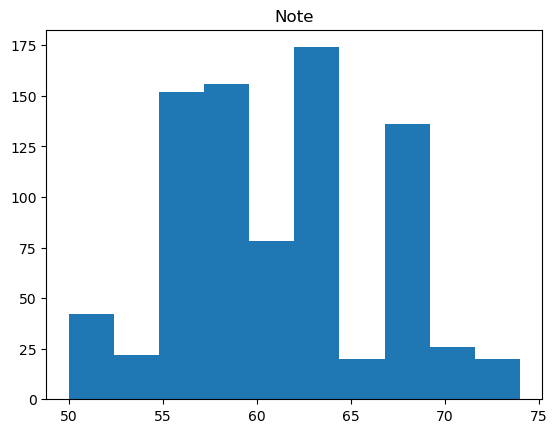

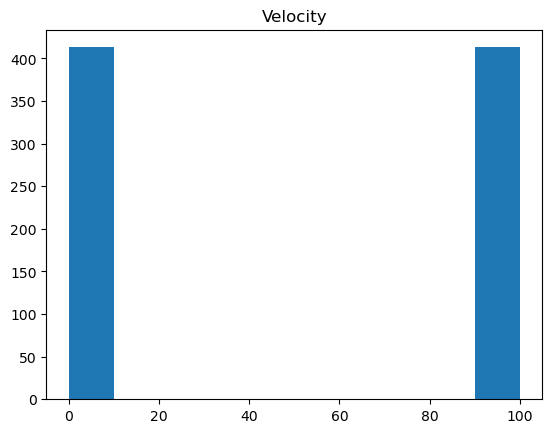

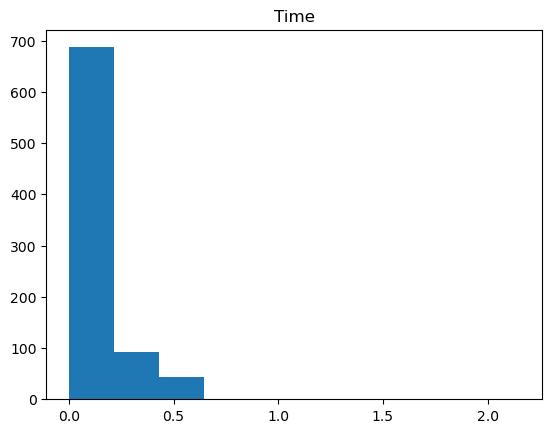

In [2]:
# 从硬盘中读入MIDI音乐文件
#mid = MidiFile('./music/allegroconspirito.mid') # a Mozart piece
mid = MidiFile('./music/krebs.mid')  # a Mozart piece

notes = []

time = float(0)
prev = float(0)

original = []  # original记载了原始message数据，以便后面的比较

# 对MIDI文件中所有的消息进行循环
for msg in mid:
    # 时间的单位是秒，而不是帧
    time += msg.time

    # 如果当前消息不是描述信息
    if not msg.is_meta:
        # 仅提炼第一个channel的音符
        if msg.channel == 0:
            # 如果当前音符为打开的
            if msg.type == 'note_on':
                # 获得消息中的信息（编码在字节中）
                note = msg.bytes()
                # 我们仅对音符信息感兴趣. 音符消息按如下形式记录 [type, note, velocity]
                note = note[1:3]  #操作完这一步后，note[0]存音符，note[1]存速度（力度）
                # note[2]存据上一个message的时间间隔
                note.append(time - prev)
                prev = time
                # 将音符添加到列表notes中
                notes.append(note)
                # 在原始列表中保留这些音符
                original.append([i for i in note])

# 绘制每一个分量的直方图，方便看出每一个量的取值范围
plt.figure()
plt.hist([i[0] for i in notes])
plt.title('Note')
plt.figure()
plt.hist([i[1] for i in notes])
plt.title('Velocity')
plt.figure()
plt.hist([i[2] for i in notes])
plt.title('Time')
plt.show()


### 2. 将每一个Message进行编码

原始的数据是形如(78, 0, 0.0108)这样的三元组

编码后的数据格式为：(00...010..., 100..., 0100...)这样的三个one-hot向量，第一个向量长度89，第二个128，第三个11

In [12]:
# note和velocity都可以看作是类型变量
# time为float，我们按照区间将其也化成离散的类型变量
# 首先，我们找到time变量的取值区间，并进行划分。由于大量msg的time为0，因此我们把0归为了一个特别的类
intervals = 10
values = np.array([i[2] for i in notes])
max_t = np.amax(values)  #区间中的最大值
min_t = np.amin(values[values > 0])  #区间中的最小值
interval = 1.0 * (max_t - min_t) / intervals

# 接下来，我们将每一个message编码成三个one-hot向量，将这三个向量合并到一起就构成了slot向量
dataset = []
for note in notes:
    slot = np.zeros(89 + 128 + 12)

    #由于note是介于24-112之间的，因此减24
    ind1 = note[0] - 24
    ind2 = note[1]
    # 由于message中有大量的time=0的情况，因此我们将0分为单独的一类，其他的都是按照区间划分
    ind3 = int((note[2] - min_t) / interval + 1) if note[2] > 0 else 0
    slot[ind1] = 1
    slot[89 + ind2] = 1
    slot[89 + 128 + ind3] = 1
    # 将处理后得到的slot数组加入到dataset中
    dataset.append(slot)

### 3.生成训练集和校验集，装进数据加载器

我们将整个音符三元组（note，velocity，time）序列按照31位长度的滑动窗口切分成了len(dataset)-n_prev组

每一组的前30位作为输入，最后一位作为输出形成了训练数据

In [13]:
# 生成训练集和校验集
X = []
Y = []
# 首先，按照预测的模式，我们将原始数据生成一对一对的训练数据
n_prev = 30  # 滑动窗口长度为30

# 对数据中的所有数据进行循环
for i in range(len(dataset) - n_prev):
    # 往后取n_prev个note作为输入属性
    x = dataset[i:i + n_prev]
    # 将第n_prev+1个note（编码前）作为目标属性
    y = notes[i + n_prev]
    # 注意time要转化成类别的形式
    ind3 = int((y[2] - min_t) / interval + 1) if y[2] > 0 else 0
    y[2] = ind3

    # 将X和Y加入到数据集中
    X.append(x)
    Y.append(y)

# 将数据集中的前n_prev个音符作为种子，用于生成音乐的时候用
seed = dataset[0:n_prev]

# 对所有数据顺序打乱重排
idx = np.random.permutation(range(len(X)))
# 形成训练与校验数据集列表
X = [X[i] for i in idx]
Y = [Y[i] for i in idx]

# 从中切分1/10的数据出来放入校验集
validX = X[: len(X) // 10]
X = X[len(X) // 10:]
validY = Y[: len(Y) // 10]
Y = Y[len(Y) // 10:]

# 将列表再转化为dataset，并用dataloader来加载数据
# dataloader是PyTorch开发采用的一套管理数据的方法。通常数据的存储放在dataset中，而对数据的调用则是通过data loader完成的
# 同时，在进行预处理的时候，系统已经自动将数据打包成撮（batch），每次调用，我们都提取一整个撮出来（包含多条记录）
# 从dataloader中吐出的每一个元素都是一个(x,y)元组，其中x为输入的张量，y为标签。x和y的第一个维度都是batch_size大小。

batch_size = 30  #一撮包含30个数据记录，这个数字越大，系统在训练的时候，每一个周期处理的数据就越多，这样处理越快，但总的数据量会减少

# 形成训练集
train_ds = DataSet.TensorDataset(torch.FloatTensor(np.array(X, dtype=float)), torch.LongTensor(np.array(Y)))
# 形成数据加载器
train_loader = DataSet.DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)

# 校验数据
valid_ds = DataSet.TensorDataset(torch.FloatTensor(np.array(validX, dtype=float)), torch.LongTensor(np.array(validY)))
valid_loader = DataSet.DataLoader(valid_ds, batch_size=batch_size, shuffle=True, num_workers=4)


## 二、定义一个LSTM网络

该网络特殊的地方在于它的输出，对于每一个样本，它会输出三个变量x,y,z，它们分别是一个归一化的概率向量

分别用来预测类型化了的note、velocity和time

在网络中我们对lstm的输出结果进行dropout的操作，所谓的dropout就是指在训练的截断，系统会随机删除掉一些神经元，
，而在测试阶段则不会删掉神经元，这样使得模型给出正确的输出会更加困难，从避免了过拟合现象。

In [14]:

class LSTMNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, out_size, n_layers=1):
        super(LSTMNetwork, self).__init__()
        self.n_layers = n_layers

        self.hidden_size = hidden_size
        self.out_size = out_size
        # 一层LSTM单元
        self.lstm = nn.LSTM(input_size, hidden_size, n_layers, batch_first=True)
        # 一个Dropout部件，以0.2的概率Dropout
        self.dropout = nn.Dropout(0.2)
        # 一个全链接层
        self.fc = nn.Linear(hidden_size, out_size)
        # 对数Softmax层
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden=None):
        # 神经网络的每一步运算

        hhh1 = hidden[0]  #读如隐含层的初始信息

        # 完成一步LSTM运算
        # input的尺寸为：batch_size , time_step, input_size
        output, hhh1 = self.lstm(input, hhh1)  #input:batchsize*timestep*3
        # 对神经元输出的结果进行dropout
        output = self.dropout(output)
        # 取出最后一个时刻的隐含层输出值
        # output的尺寸为：batch_size, time_step, hidden_size
        output = output[:, -1, ...]
        # 此时，output的尺寸为：batch_size, hidden_size
        # 喂入一个全链接层
        out = self.fc(output)
        # out的尺寸为：batch_size, output_size

        # 将out的最后一个维度分割成三份x, y, z分别对应对note，velocity以及time的预测

        x = self.softmax(out[:, :89])
        y = self.softmax(out[:, 89: 89 + 128])
        z = self.softmax(out[:, 89 + 128:])

        # x的尺寸为batch_size, 89
        # y的尺寸为batch_size, 128
        # z的尺寸为batch_size, 11
        # 返回x,y,z
        return (x, y, z)

    def initHidden(self, batch_size):
        # 对隐含层单元变量全部初始化为0
        # 注意尺寸是： layer_size, batch_size, hidden_size
        out = []
        hidden1 = torch.zeros(1, batch_size, self.hidden_size)
        cell1 = torch.zeros(1, batch_size, self.hidden_size)
        out.append((hidden1, cell1))
        return out

In [15]:
def criterion(outputs, target):
    # 为本模型自定义的损失函数，它由三部分组成，每部分都是一个交叉熵损失函数，
    # 它们分别对应note、velocity和time的交叉熵
    x, y, z = outputs
    loss_f = nn.NLLLoss()
    loss1 = loss_f(x, target[:, 0])
    loss2 = loss_f(y, target[:, 1])
    loss3 = loss_f(z, target[:, 2])
    return loss1 + loss2 + loss3


def rightness(predictions, labels):
    """计算预测错误率的函数，其中predictions是模型给出的一组预测结果，batch_size行num_classes列的矩阵，labels是数据之中的正确答案"""
    pred = torch.max(predictions.data, 1)[1]  # 对于任意一行（一个样本）的输出值的第1个维度，求最大，得到每一行的最大元素的下标
    rights = pred.eq(labels.data).sum()  #将下标与labels中包含的类别进行比较，并累计得到比较正确的数量
    return rights, len(labels)  #返回正确的数量和这一次一共比较了多少元素

#### 开始训练一个LSTM。

In [16]:
# 定义一个LSTM，其中输入输出层的单元个数取决于每个变量的类型取值范围
lstm = LSTMNetwork(89 + 128 + 12, 128, 89 + 128 + 12)
optimizer = optim.Adam(lstm.parameters(), lr=0.001)
num_epochs = 100
train_losses = []
valid_losses = []
records = []

# 开始训练循环
for epoch in range(num_epochs):
    train_loss = []
    # 开始遍历加载器中的数据
    for batch, data in enumerate(train_loader):
        # batch为数字，表示已经进行了第几个batch了
        # data为一个二元组，分别存储了一条数据记录的输入和标签
        # 每个数据的第一个维度都是batch_size = 30的数组

        lstm.train()  # 标志LSTM当前处于训练阶段，Dropout开始起作用
        init_hidden = lstm.initHidden(len(data[0]))  # 初始化LSTM的隐单元变量
        optimizer.zero_grad()
        #         print(data[0].size())
        #         print(data[1])
        #         print(data[1].size())
        x, y = data[0].clone().detach().requires_grad_(True), data[1].clone().detach()  # 从数据中提炼出输入和输出对
        outputs = lstm(x, init_hidden)  #喂入LSTM，产生输出outputs
        #         print(outputs[1].size())
        #         print(outputs[0].size())
        #         print(outputs[2].size())

        loss = criterion(outputs, y)  #代入损失函数并产生loss
        #         print(loss.data.numpy())
        train_loss.append(loss.data.numpy())  # 记录loss
        loss.backward()  #反向传播
        optimizer.step()  #梯度更新
    if 0 == 0:
        #在校验集上跑一遍，并计算在校验集上的分类准确率
        valid_loss = []
        lstm.eval()  #将模型标志为测试状态，关闭dropout的作用
        rights = []
        # 遍历加载器加载进来的每一个元素
        for batch, data in enumerate(valid_loader):
            init_hidden = lstm.initHidden(len(data[0]))
            #完成LSTM的计算
            x, y = data[0].clone().detach().requires_grad_(True), data[1].clone().detach()
            #x的尺寸：batch_size, length_sequence, input_size
            #y的尺寸：batch_size, (data_dimension1=89+ data_dimension2=128+ data_dimension3=12)
            outputs = lstm(x, init_hidden)
            #outputs: (batch_size*89, batch_size*128, batch_size*11)
            loss = criterion(outputs, y)
            valid_loss.append(loss.data.numpy())
            #计算每个指标的分类准确度
            right1 = rightness(outputs[0], y[:, 0])
            right2 = rightness(outputs[1], y[:, 1])
            right3 = rightness(outputs[2], y[:, 2])
            rights.append((right1[0] + right2[0] + right3[0]).numpy() * 1.0 / (right1[1] + right2[1] + right3[1]))
        # 打印结果
        print('第{}轮, 训练Loss:{:.2f}, 校验Loss:{:.2f}, 校验准确度:{:.2f}'.format(epoch,
                                                                                   np.mean(train_loss),
                                                                                   np.mean(valid_loss),
                                                                                   np.mean(rights)
                                                                                   ))
        records.append([np.mean(train_loss), np.mean(valid_loss), np.mean(rights)])

第0轮, 训练Loss:9.35, 校验Loss:5.01, 校验准确度:0.33
第1轮, 训练Loss:4.46, 校验Loss:4.35, 校验准确度:0.36
第2轮, 训练Loss:4.26, 校验Loss:4.33, 校验准确度:0.51
第3轮, 训练Loss:4.25, 校验Loss:4.27, 校验准确度:0.38
第4轮, 训练Loss:4.12, 校验Loss:4.10, 校验准确度:0.61
第5轮, 训练Loss:3.89, 校验Loss:3.80, 校验准确度:0.60
第6轮, 训练Loss:3.54, 校验Loss:3.46, 校验准确度:0.66
第7轮, 训练Loss:3.36, 校验Loss:3.42, 校验准确度:0.64
第8轮, 训练Loss:3.27, 校验Loss:3.29, 校验准确度:0.65
第9轮, 训练Loss:3.23, 校验Loss:3.30, 校验准确度:0.67
第10轮, 训练Loss:3.18, 校验Loss:3.32, 校验准确度:0.66
第11轮, 训练Loss:3.11, 校验Loss:3.24, 校验准确度:0.66
第12轮, 训练Loss:3.09, 校验Loss:3.22, 校验准确度:0.64
第13轮, 训练Loss:3.02, 校验Loss:3.18, 校验准确度:0.67
第14轮, 训练Loss:2.97, 校验Loss:3.14, 校验准确度:0.67
第15轮, 训练Loss:2.93, 校验Loss:3.12, 校验准确度:0.66
第16轮, 训练Loss:2.88, 校验Loss:3.18, 校验准确度:0.65
第17轮, 训练Loss:2.84, 校验Loss:2.97, 校验准确度:0.68
第18轮, 训练Loss:2.78, 校验Loss:3.06, 校验准确度:0.67
第19轮, 训练Loss:2.73, 校验Loss:2.95, 校验准确度:0.70
第20轮, 训练Loss:2.72, 校验Loss:2.99, 校验准确度:0.67
第21轮, 训练Loss:2.66, 校验Loss:2.94, 校验准确度:0.68
第22轮, 训练Loss:2.62, 校验Loss:2.91, 校验准确度:0.69
第23轮, 训练Loss:2.58, 校验

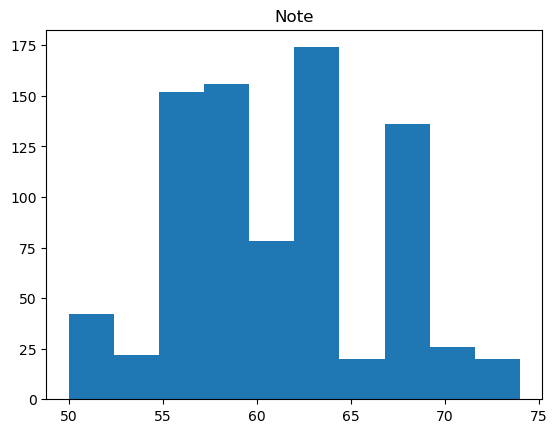

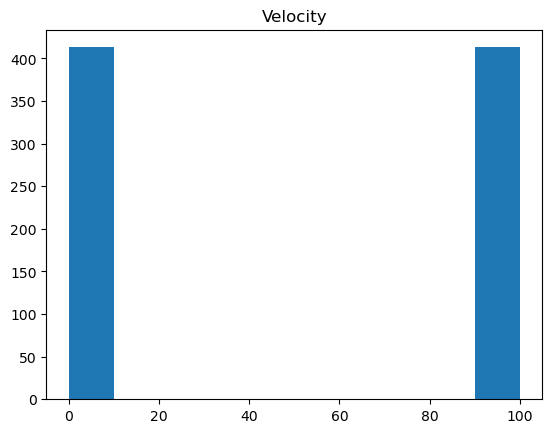

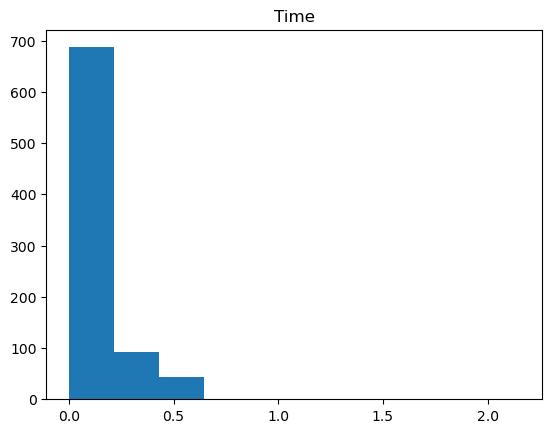

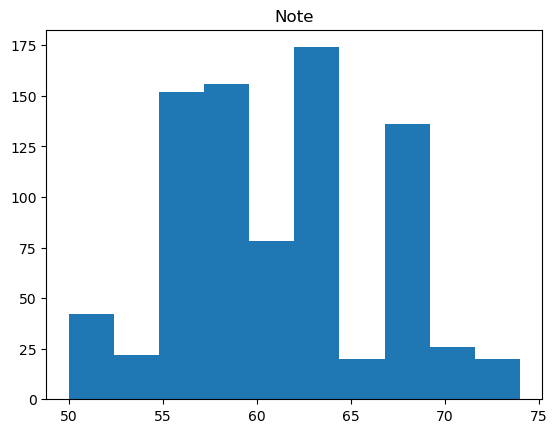

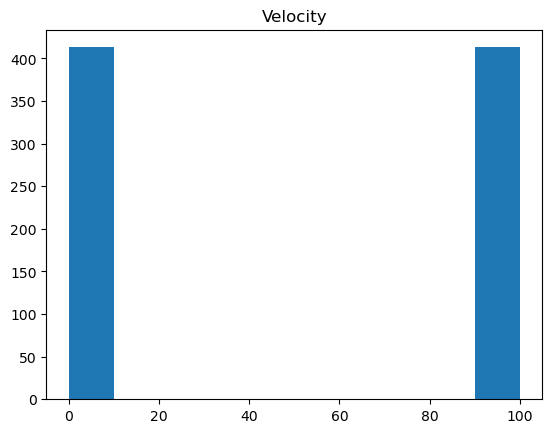

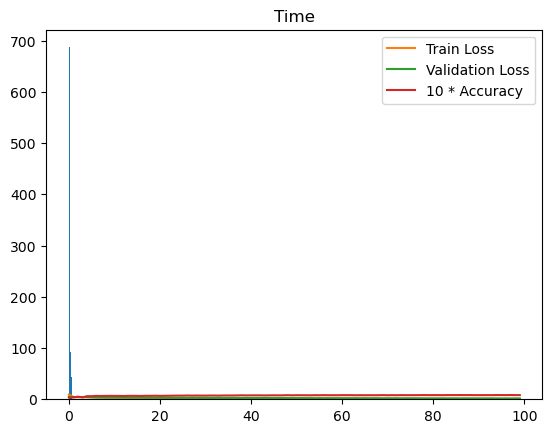

In [17]:
# 绘制训练过程中的Loss曲线
a = [i[0] for i in records]
b = [i[1] for i in records]
c = [i[2] * 10 for i in records]
plt.plot(a, '-', label='Train Loss')
plt.plot(b, '-', label='Validation Loss')
plt.plot(c, '-', label='10 * Accuracy')
plt.legend()
plt.show()

## 三、音乐生成

我们运用训练好的LSTM来生成音符。首先把seed喂给LSTM并产生第n_prev + 1个msg，然后把这个msg加到输入数据的最后面，删除第一个元素

这就又构成了一个标准的输入序列；然后再得到下一个msg，……，如此循环往复得到音符序列的生成

In [18]:
# 生成3000步
predict_steps = 3000

# 初始时刻，将seed（一段种子音符，即我为开始读入的音乐文件）付给x
x = seed
# 将数据扩充为合适的形式
x = np.expand_dims(x, axis=0)
# 现在的x的尺寸为：batch=1, time_step =30, data_dim = 229

lstm.eval()
initi = lstm.initHidden(1)
predictions = []
# 开始每一步的迭代
for i in range(predict_steps):
    # 根据前n_prev预测后面的一个音符
    xx = torch.tensor(np.array(x, dtype=float), dtype=torch.float, requires_grad=True)
    preds = lstm(xx, initi)

    # 返回预测的note，velocity，time的模型预测概率对数
    a, b, c = preds
    # a的尺寸为：batch=1*data_dim=89, b为1*128，c为1*11

    # 将概率对数转化为随机的选择
    ind1 = torch.multinomial(a.view(-1).exp(), num_samples=1)
    ind2 = torch.multinomial(b.view(-1).exp(), num_samples=1)
    ind3 = torch.multinomial(c.view(-1).exp(), num_samples=1)

    ind1 = ind1.data.numpy()[0]  # 0-89中的整数
    ind2 = ind2.data.numpy()[0]  # 0-128中的整数
    ind3 = ind3.data.numpy()[0]  # 0-11中的整数

    # 将选择转换为正确的音符等数值，注意time分为11类，第一类为0这个特殊的类，其余按照区间放回去
    note = [ind1 + 24, ind2, 0 if ind3 == 0 else ind3 * interval + min_t]

    # 将预测的内容存储下来
    predictions.append(note)

    # 将新的预测内容再次转变为输入数据准备喂给LSTM
    slot = np.zeros(89 + 128 + 12, dtype=int)
    slot[ind1] = 1
    slot[89 + ind2] = 1
    slot[89 + 128 + ind3] = 1
    slot1 = np.expand_dims(slot, axis=0)
    slot1 = np.expand_dims(slot1, axis=0)

    #slot1的数据格式为：batch=1*time=1*data_dim=229

    # x拼接上新的数据
    x = np.concatenate((x, slot1), 1)
    # 现在x的尺寸为: batch_size = 1 * time_step = 31 * data_dim =229

    # 滑动窗口往前平移一次
    x = x[:, 1:, :]
    # 现在x的尺寸为：batch_size = 1 * time_step = 30 * data_dim = 229


In [19]:
# 将生成的序列转化为MIDI的消息，并保存MIDI音乐
mid = MidiFile()
track = MidiTrack()
mid.tracks.append(track)

for i, note in enumerate(predictions):
    # 在note一开始插入一个147表示打开note_on
    note = np.insert(note, 0, 147)
    # 将整数转化为字节
    bytes = note.astype(int)
    # 创建一个message
    msg = Message.from_bytes(bytes[0:3])
    # 0.001025为任意取值，可以调节音乐的速度。由于生成的time都是一系列的间隔时间，转化为msg后时间尺度过小，因此需要调节放大
    time = int(note[3] / 0.001025)
    msg.time = time
    # 将message添加到音轨中
    track.append(msg)

#保存文件
mid.save('music/new_song.mid')
###########################################